In [1]:
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import os
import PIL
import PIL.Image
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing import image
import dask.bag as bag
from dask.diagnostics import ProgressBar
import matplotlib.cm as cm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Exploratory data analysis

This block of code initializes file paths for the folders and images that are going to be used for the exploratory data analysis.

In [2]:
train_dir = Path('dataset2/train')
train_filepaths_jpg = list(train_dir.rglob(r'**/*.jpg'))
train_filepaths_jpeg = list(train_dir.rglob(r'**/*.jpeg'))
train_filepaths_png = list(train_dir.rglob(r'**/*.png'))
train_filepaths = train_filepaths_jpg + train_filepaths_jpeg + train_filepaths_png


def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
train_df = train_df.sort_values("Label")
labels = train_df["Label"].unique()
labels.sort()
# train_df
# train_df.loc[train_df["Label"] == label]

i=0
imagePath = {}

for label in labels:
    imagePath[i] = [fn for fn in os.listdir(f'{train_dir}\\{label}') if fn.endswith('.jpg')]
    temp = [fn for fn in os.listdir(f'{train_dir}\\{label}') if fn.endswith('.png')]
    for j in temp:
        imagePath[i].append(j)
    temp = [fn for fn in os.listdir(f'{train_dir}\\{label}') if fn.endswith('.jpeg')]
    for j in temp:
        imagePath[i].append(j)
    i+=1

# Distribution of Sizes
The distribution of sizes is shown by obtaining the dimensions of the image namely its height, weight, and depth if it has depth. The height and weight are then compiled into a scatterplot for easy visualization with each fruit and vegetable having its own graph. Knowing the distribution of sizes can help us understand which size is appropriate to be used for pre-processing purposes to normalize the sizes of each image and better tune the model.

In [3]:
# Distribution of Sizes
classDirectories = {}
for label in labels:
    classDirectories[label] = 'dataset2/train/' + label + '/'

def get_dims(file):
    im = Image.open(file)
    arr = np.array(im)
    if (len(arr.shape) == 3):
        h,w,d = arr.shape
    else:
        h,w = arr.shape
    return h,w

[########################################] | 100% Completed |  3.1s
[########################################] | 100% Completed |  3.6s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  4.0s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  3.7s
[########################################] | 100

C:\Users\Allen\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  4.1s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  1.8s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  3.8s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.3s
[########################################] | 100% Completed |  3.5s


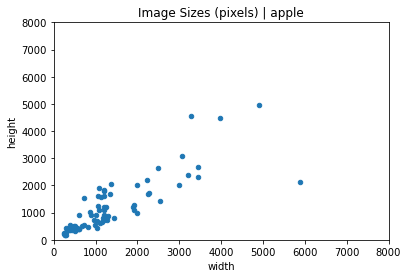

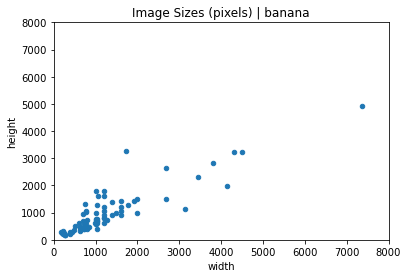

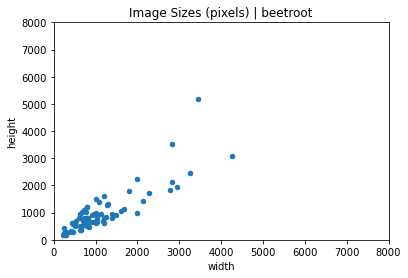

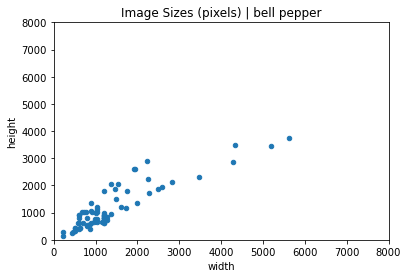

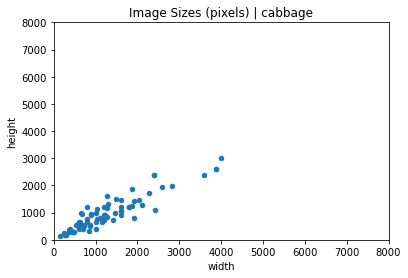

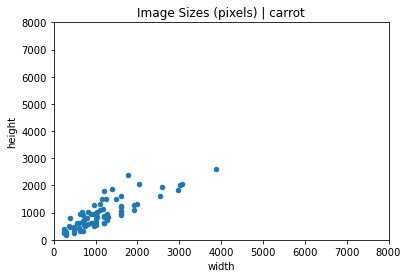

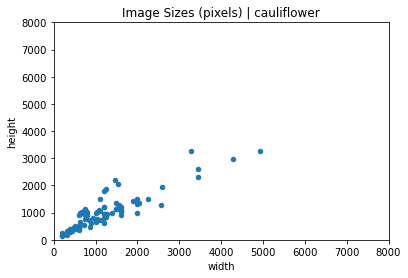

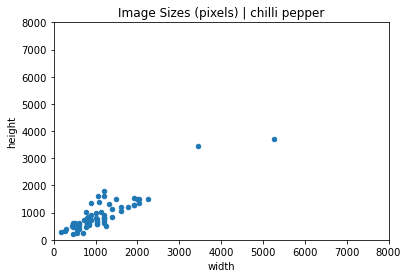

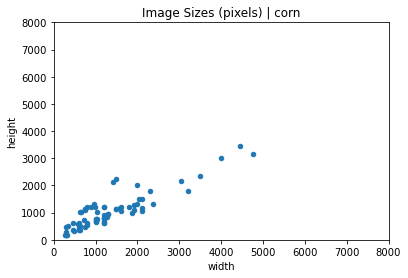

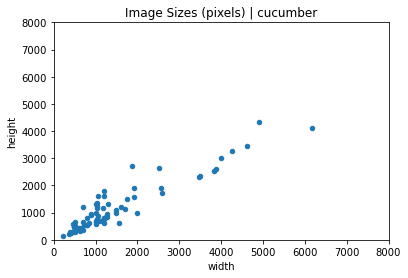

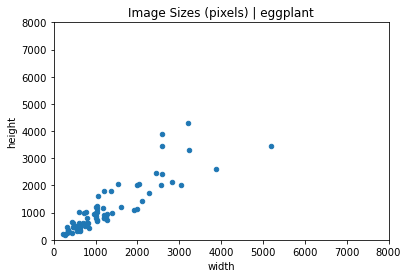

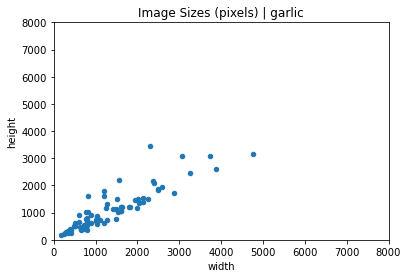

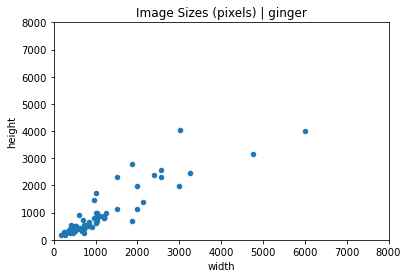

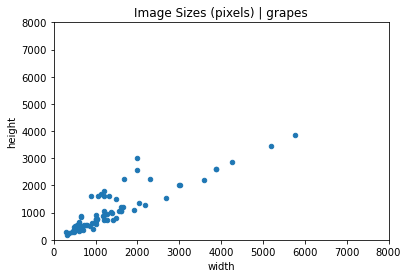

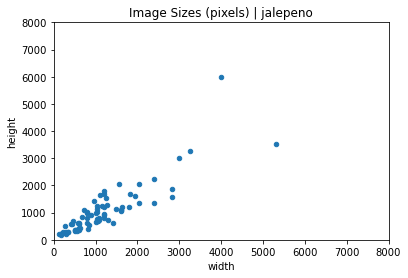

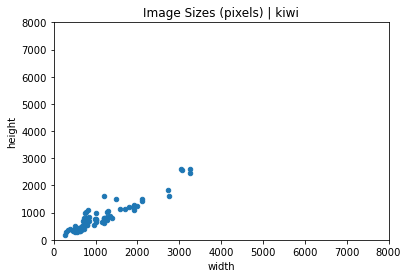

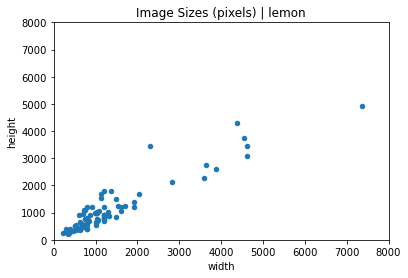

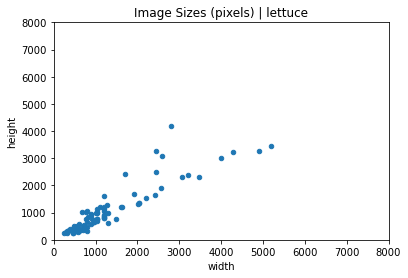

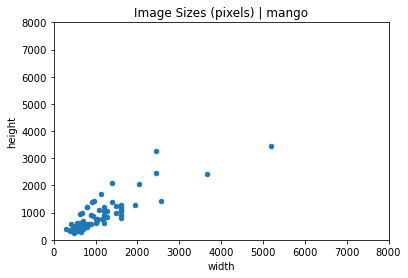

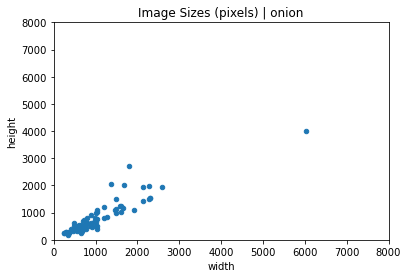

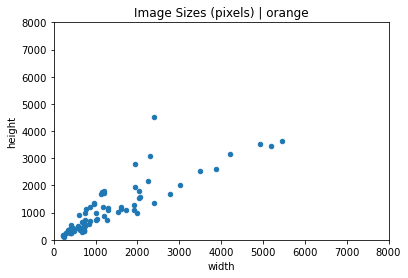

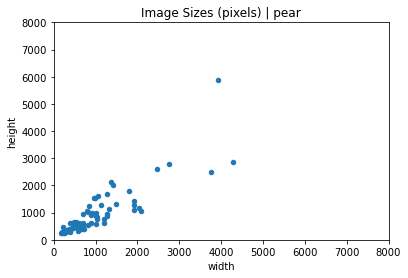

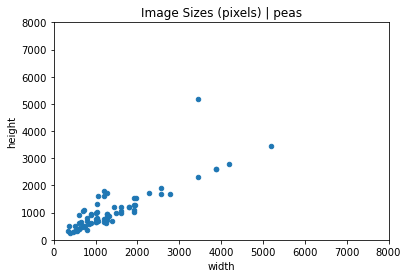

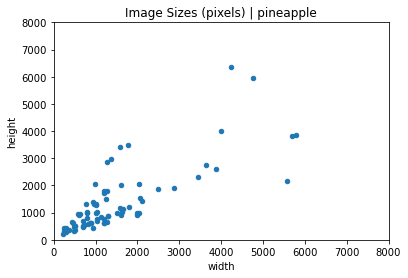

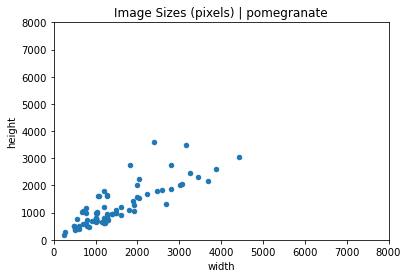

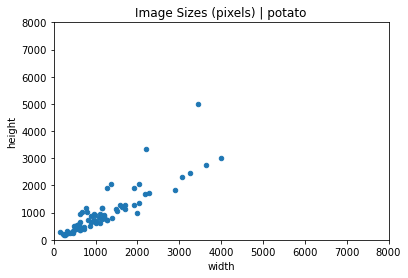

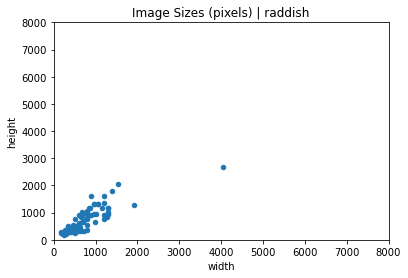

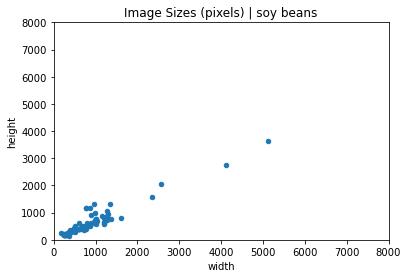

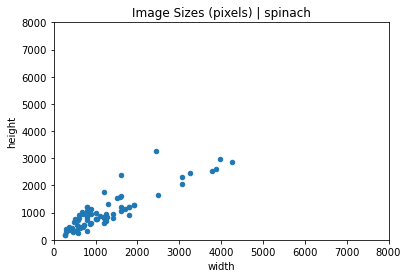

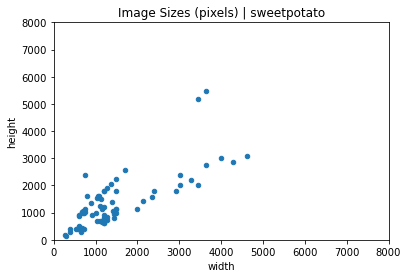

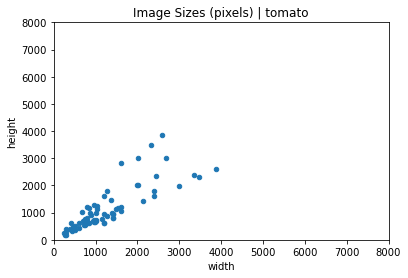

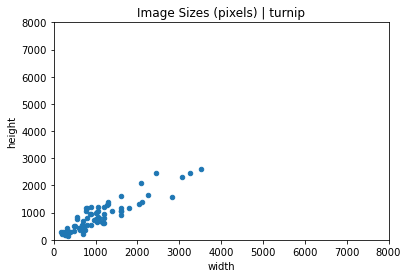

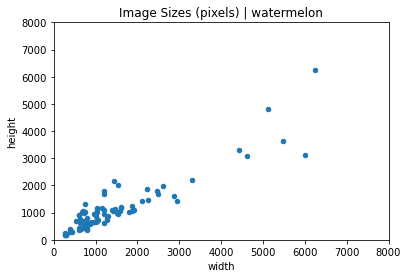

In [4]:
for n,d in classDirectories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)
    with ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height');
        plt.xlim(0, 8000)
        plt.ylim(0, 8000)
        plt.title('Image Sizes (pixels) | {}'.format(n))

It can be seen from the results above that most images gather around the 0-2000 height and width so it is important to run it again and limit the view to those of that size.

[########################################] | 100% Completed |  2.8s
[########################################] | 100% Completed |  3.4s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  3.9s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.4s
[########################################] | 100% Completed |  2.5s
[########################################] | 100% Completed |  2.2s
[########################################] | 100% Completed |  2.6s
[########################################] | 100% Completed |  3.0s
[########################################] | 100% Completed |  2.9s
[########################################] | 100% Completed |  3.2s
[########################################] | 100% Completed |  2.7s
[########################################] | 100% Completed |  3.7s
[########################################] | 100

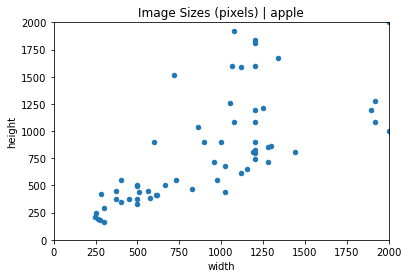

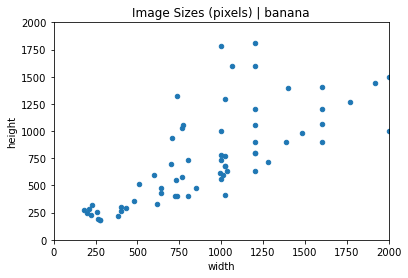

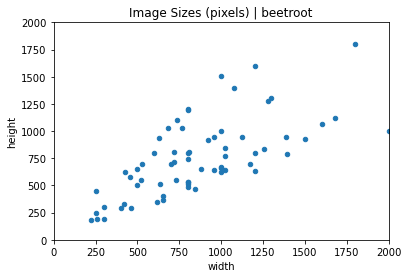

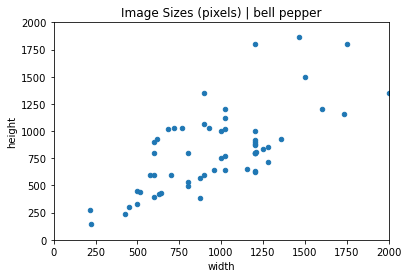

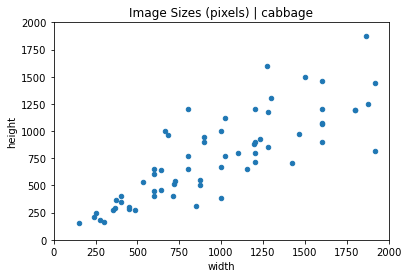

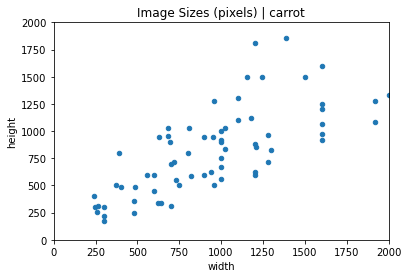

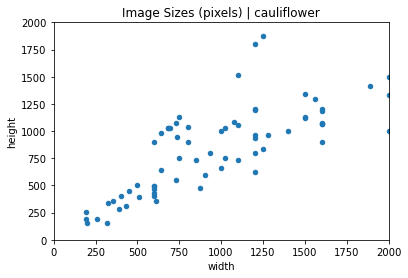

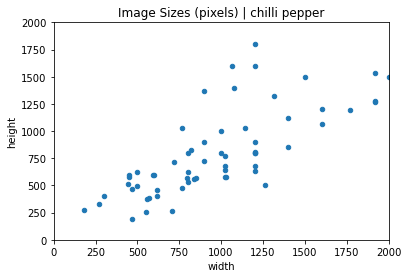

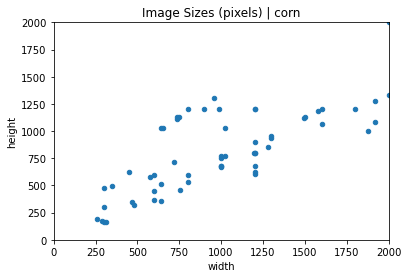

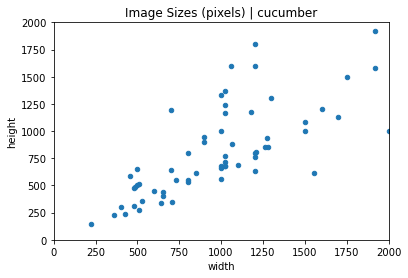

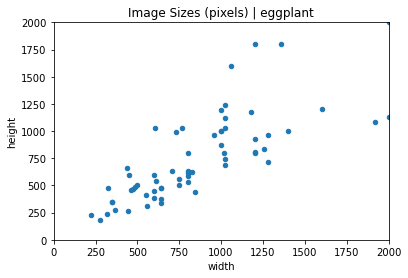

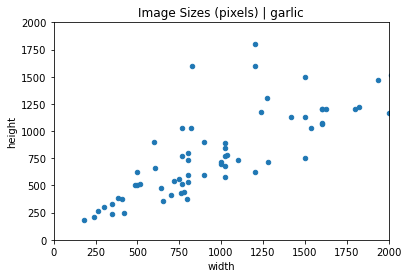

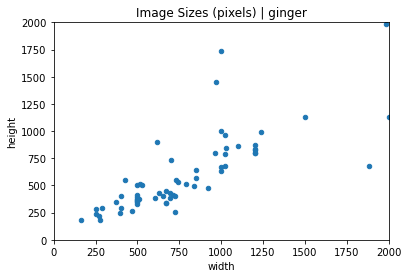

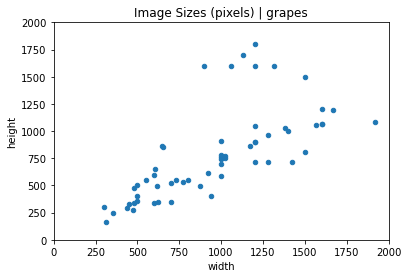

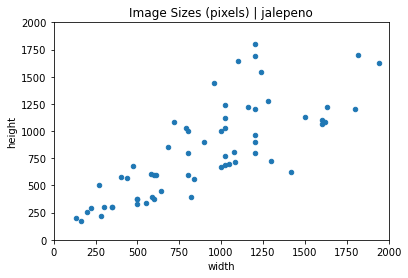

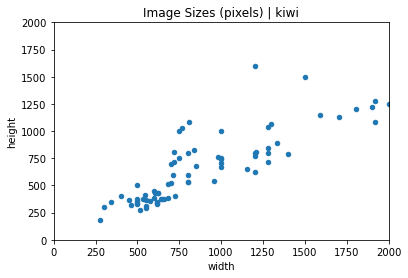

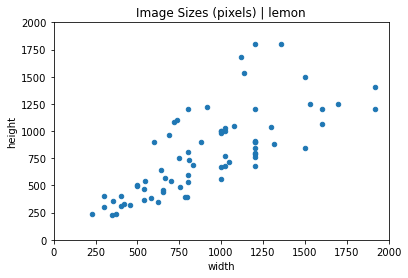

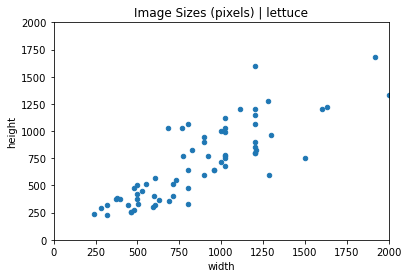

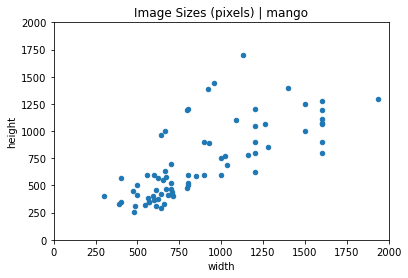

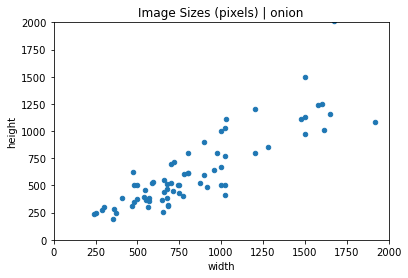

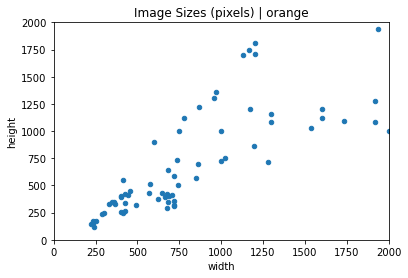

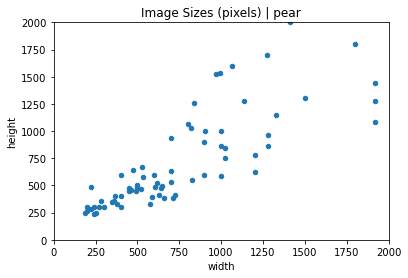

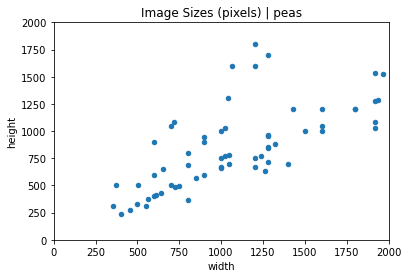

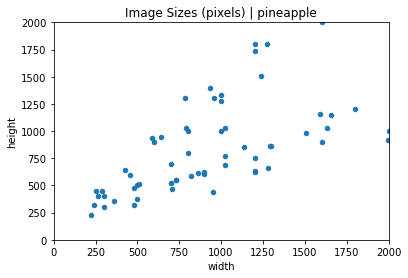

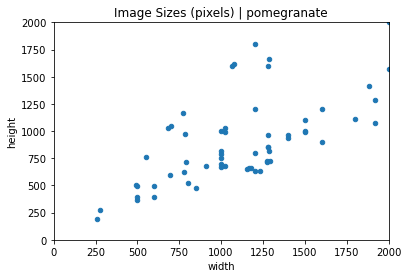

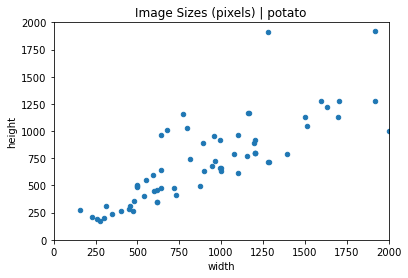

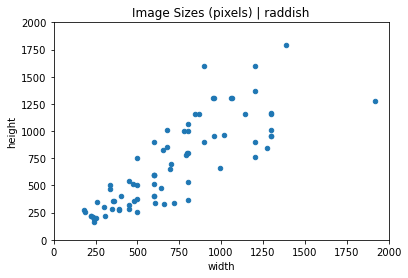

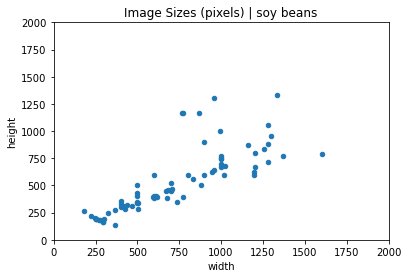

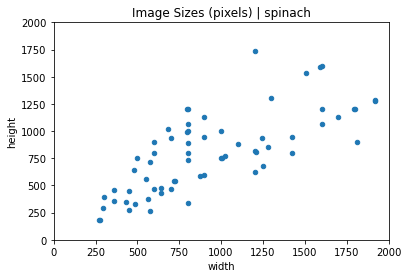

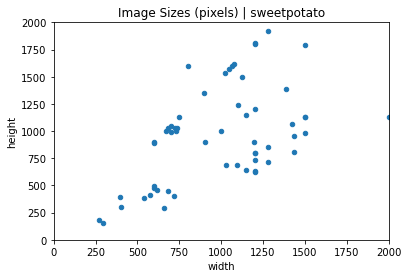

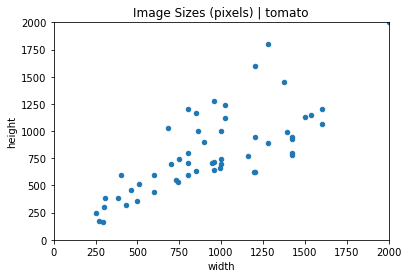

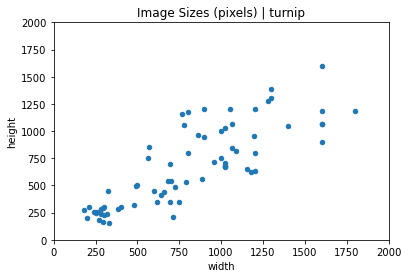

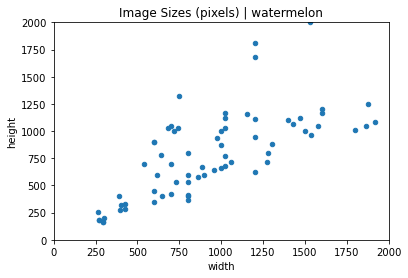

In [5]:
for n,d in classDirectories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    dims = bag.from_sequence(filelist).map(get_dims)
    with ProgressBar():
        dims = dims.compute()
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
        sizes.plot.scatter(x='width', y='height');
        plt.xlim(0, 2000)
        plt.ylim(0, 2000)
        plt.title('Image Sizes (pixels) | {}'.format(n))

It can be observed that most images land in the size 250x250 to 750x750

# Distribution of Labels
By checking the directories of each label the amount of images per fruit and vegetable can be shown in a bar graph with number of images in the y-axis and label in the x-axis. Knowing the proper distrubtion of labels can help determine which image has a different count from others. It is important for each label to have the same amount of images as it may affect the training of the model later on.

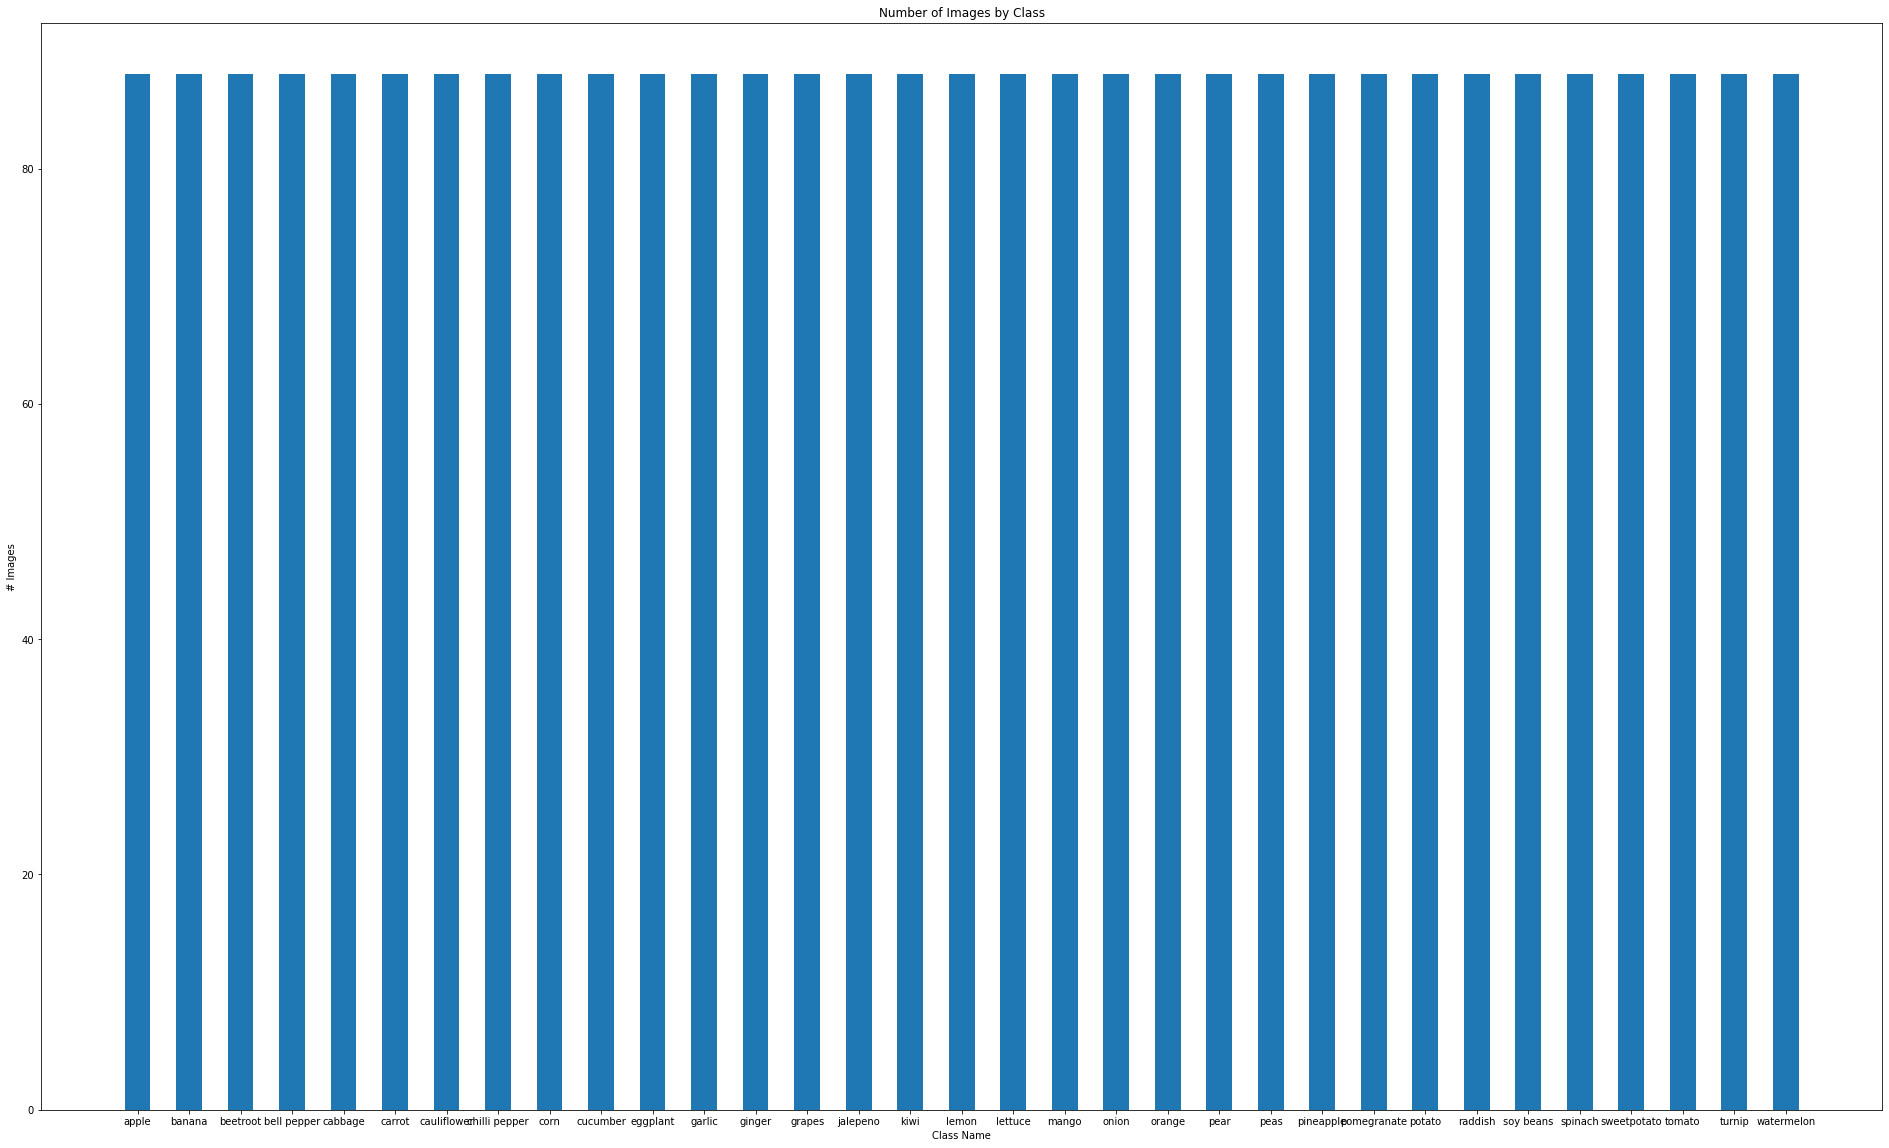

In [6]:
# Distribution of Labels
number_classes = {}
for label in labels:
    number_classes[label] = len(os.listdir(f'{train_dir}\\{label}'))
f, ax = plt.subplots(figsize=(33,20)) # set the size that you'd like (width, height)
plt.bar(number_classes.keys(), number_classes.values(), width = .5)
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

# Model

In [7]:
# Create a list with the filepaths for training and testing
train_dir = Path('dataset2/train')
train_filepaths = list(train_dir.glob(r'*/*'))

test_dir = Path('dataset2/test')
test_filepaths = list(test_dir.glob(r'*/*'))

val_dir = Path('dataset2/validation')
val_filepaths = list(val_dir.glob(r'*/*'))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

In [3]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2904

Number of different labels: 33

Labels: ['lemon' 'chilli pepper' 'soy beans' 'grapes' 'jalepeno' 'beetroot'
 'pineapple' 'banana' 'turnip' 'eggplant' 'peas' 'sweetpotato' 'carrot'
 'corn' 'onion' 'watermelon' 'garlic' 'tomato' 'ginger' 'cauliflower'
 'raddish' 'cabbage' 'pear' 'orange' 'pomegranate' 'potato' 'lettuce'
 'bell pepper' 'mango' 'cucumber' 'spinach' 'kiwi' 'apple']


In [4]:
train_df.head(5)

,Filepath,Label
0,dataset2\train\lemon\Image_61.png,lemon
1,dataset2\train\chilli pepper\Image_39.jpg,chilli pepper
2,dataset2\train\soy beans\Image_51.jpg,soy beans
3,dataset2\train\grapes\Image_82.JPG,grapes
4,dataset2\train\jalepeno\Image_26.jpg,jalepeno


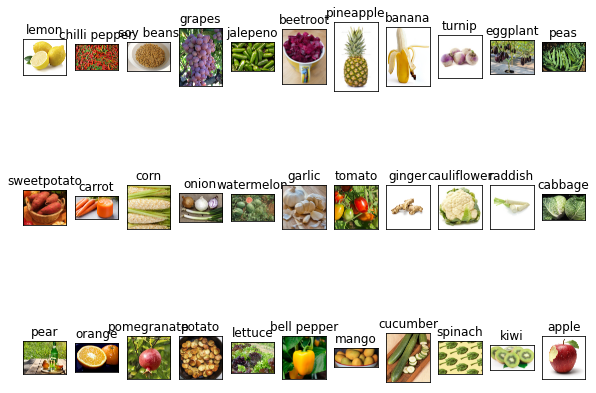

In [5]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=3, ncols=11, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2904 validated image filenames belonging to 33 classes.
Found 726 validated image filenames belonging to 33 classes.
Found 330 validated image filenames belonging to 33 classes.


# Hyperparameter Tuning

In [19]:
pt_hyperparameters = ['avg', 'max']

adam_hyperparameters = [0.0001, 0.001, 0.01]

In [20]:
best_score = 0
for p in pt_hyperparameters :
    
    pretrained_model = tf.keras.applications.InceptionV3(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling=p
    )
    pretrained_model.trainable = False
    
    for l in adam_hyperparameters:
        print('=============================')
        print('POOLING: ' + p)
        print('LEARNING RATE: ' + str(l))
        inputs = pretrained_model.input

        x = tf.keras.layers.Dropout(0.2)(pretrained_model.output)
        outputs = tf.keras.layers.Dense(33, activation='softmax')(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=l),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        history = model.fit(
            train_images,
            validation_data=val_images,
            batch_size = 32,
            epochs=20,
        )
        
        val_acc = history.history['val_accuracy'][-1]
        
        if val_acc > best_score:
            best_score = val_acc
            best_params = {'p' : p, 'l' : l}

print("Best accuracy: ", best_score)
print("Best grid: ", best_params)

POOLING: avg
LEARNING RATE: 0.0001
Epoch 1/20
 2/91 [..............................] - ETA: 1:23 - loss: 4.3605 - accuracy: 0.0000e+00

C:\Users\JAMES SY\anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


91/91 [==============================] - 148s 2s/step - loss: 3.4861 - accuracy: 0.0926 - val_loss: 2.8301 - val_accuracy: 0.2727
Epoch 2/20
91/91 [==============================] - 147s 2s/step - loss: 2.5316 - accuracy: 0.3402 - val_loss: 2.1427 - val_accuracy: 0.5055
Epoch 3/20
91/91 [==============================] - 151s 2s/step - loss: 1.9539 - accuracy: 0.5131 - val_loss: 1.7462 - val_accuracy: 0.5909
Epoch 4/20
91/91 [==============================] - 150s 2s/step - loss: 1.5932 - accuracy: 0.5975 - val_loss: 1.5115 - val_accuracy: 0.6253
Epoch 5/20
91/91 [==============================] - 145s 2s/step - loss: 1.3608 - accuracy: 0.6591 - val_loss: 1.3567 - val_accuracy: 0.6529
Epoch 6/20
91/91 [==============================] - 142s 2s/step - loss: 1.1882 - accuracy: 0.7021 - val_loss: 1.2461 - val_accuracy: 0.6804
Epoch 7/20
91/91 [==============================] - 143s 2s/step - loss: 1.0909 - accuracy: 0.7187 - val_loss: 1.1658 - val_accuracy: 0.7052
Epoch 8/20
91/91 [======

91/91 [==============================] - 149s 2s/step - loss: 0.2802 - accuracy: 0.9518 - val_loss: 3.7367 - val_accuracy: 0.7548
Epoch 19/20
91/91 [==============================] - 148s 2s/step - loss: 0.2063 - accuracy: 0.9669 - val_loss: 4.0872 - val_accuracy: 0.7562
Epoch 20/20
91/91 [==============================] - 148s 2s/step - loss: 0.2556 - accuracy: 0.9552 - val_loss: 4.4736 - val_accuracy: 0.7562
POOLING: max
LEARNING RATE: 0.0001
Epoch 1/20
91/91 [==============================] - 152s 2s/step - loss: 5.1094 - accuracy: 0.0764 - val_loss: 3.2472 - val_accuracy: 0.2011
Epoch 2/20
91/91 [==============================] - 147s 2s/step - loss: 3.4948 - accuracy: 0.2314 - val_loss: 2.3008 - val_accuracy: 0.3939
Epoch 3/20
91/91 [==============================] - 146s 2s/step - loss: 2.6794 - accuracy: 0.3540 - val_loss: 1.8890 - val_accuracy: 0.4959
Epoch 4/20
91/91 [==============================] - 146s 2s/step - loss: 2.1951 - accuracy: 0.4463 - val_loss: 1.6291 - val_accu

91/91 [==============================] - 146s 2s/step - loss: 1.4408 - accuracy: 0.9153 - val_loss: 9.7029 - val_accuracy: 0.7176
Epoch 15/20
91/91 [==============================] - 147s 2s/step - loss: 1.4263 - accuracy: 0.9091 - val_loss: 9.5241 - val_accuracy: 0.7025
Epoch 16/20
91/91 [==============================] - 146s 2s/step - loss: 1.7297 - accuracy: 0.9001 - val_loss: 9.9589 - val_accuracy: 0.7052
Epoch 17/20
91/91 [==============================] - 147s 2s/step - loss: 1.4995 - accuracy: 0.9077 - val_loss: 10.0218 - val_accuracy: 0.7107
Epoch 18/20
91/91 [==============================] - 146s 2s/step - loss: 1.5737 - accuracy: 0.9146 - val_loss: 10.2603 - val_accuracy: 0.7149
Epoch 19/20
91/91 [==============================] - 149s 2s/step - loss: 1.2125 - accuracy: 0.9273 - val_loss: 9.6443 - val_accuracy: 0.7121
Epoch 20/20
91/91 [==============================] - 149s 2s/step - loss: 1.9502 - accuracy: 0.9050 - val_loss: 10.6591 - val_accuracy: 0.7025
Best accuracy: 

The best val_accuracy we got was 0.8060 with avg pooling and a learning rate of 0.001

In [21]:
# Load the pretained model
pretrained_model = tf.keras.applications.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [22]:
inputs = pretrained_model.input

x = tf.keras.layers.Dropout(0.2)(pretrained_model.output)
outputs = tf.keras.layers.Dense(33, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
)

Epoch 1/20
91/91 [==============================] - 152s 2s/step - loss: 1.8607 - accuracy: 0.5010 - val_loss: 1.0545 - val_accuracy: 0.6942
Epoch 2/20
91/91 [==============================] - 144s 2s/step - loss: 0.7711 - accuracy: 0.7831 - val_loss: 0.8873 - val_accuracy: 0.7410
Epoch 3/20
91/91 [==============================] - 145s 2s/step - loss: 0.5527 - accuracy: 0.8399 - val_loss: 0.8786 - val_accuracy: 0.7493
Epoch 4/20
91/91 [==============================] - 148s 2s/step - loss: 0.4228 - accuracy: 0.8846 - val_loss: 0.8020 - val_accuracy: 0.7645
Epoch 5/20
91/91 [==============================] - 149s 2s/step - loss: 0.3137 - accuracy: 0.9118 - val_loss: 0.8122 - val_accuracy: 0.7686
Epoch 6/20
91/91 [==============================] - 148s 2s/step - loss: 0.2710 - accuracy: 0.9301 - val_loss: 0.8068 - val_accuracy: 0.7700
Epoch 7/20
91/91 [==============================] - 148s 2s/step - loss: 0.2341 - accuracy: 0.9387 - val_loss: 0.7915 - val_accuracy: 0.7769
Epoch 8/20
91

In [23]:
val_acc = history.history['val_accuracy'][-1]
print(val_acc)

0.78925621509552


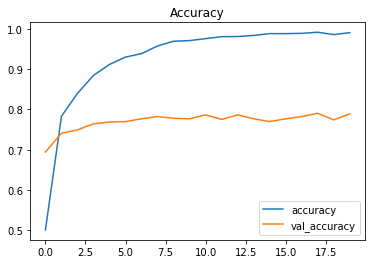

In [24]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

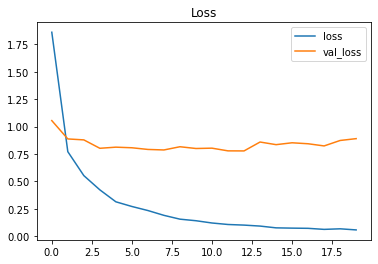

In [25]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [26]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

 3/11 [=======>......................] - ETA: 7s

C:\Users\JAMES SY\anaconda3\lib\site-packages\PIL\Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


11/11 [==============================] - 11s 833ms/step


In [27]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 82.12%


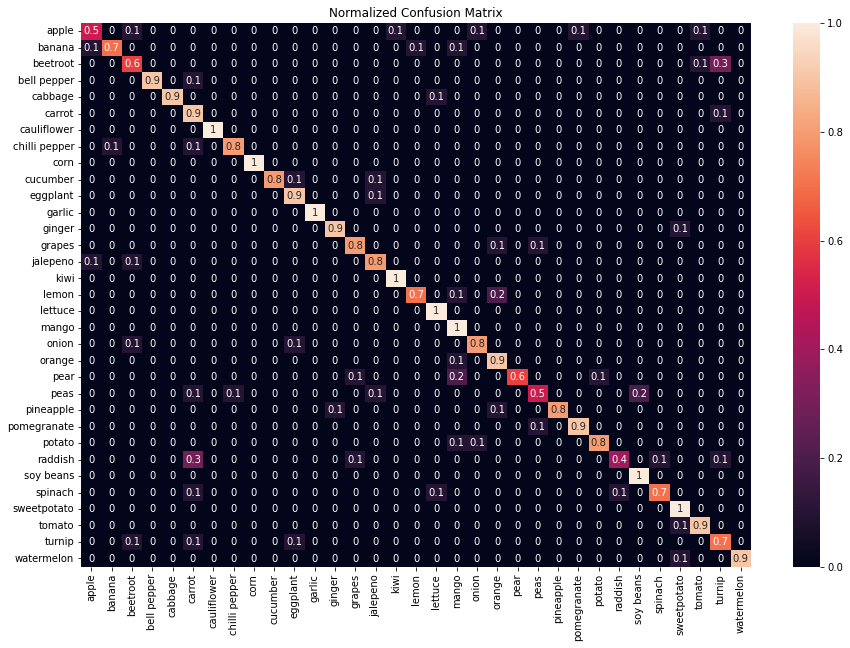

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

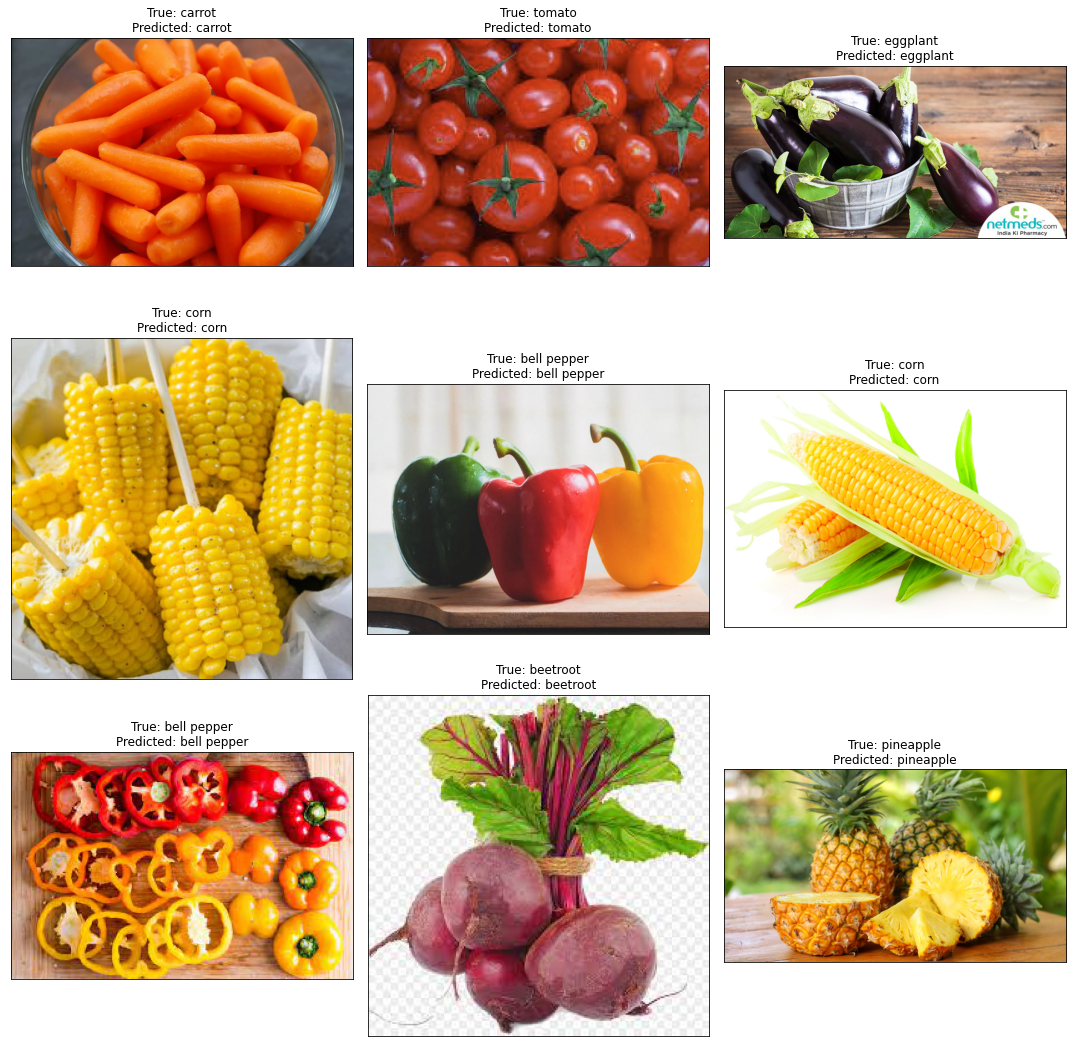

In [29]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# Heatmap

In [73]:
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0,1))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path

In [74]:
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
decode_predictions = tf.keras.applications.inception_v3.decode_predictions

last_conv_layer_name = 'activation_375'
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

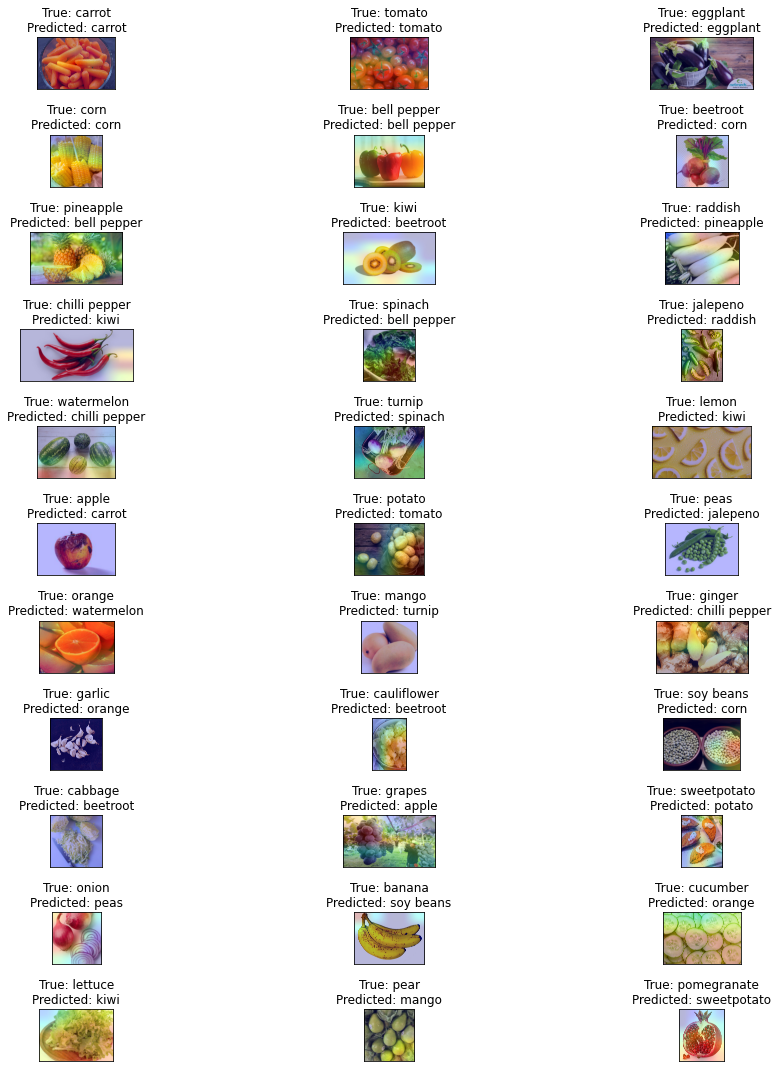

In [79]:
# Create a DataFrame with one Label of each category
df_unique = test_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# # Display some pictures of the dataset
# fig, axes = plt.subplots(nrows=3, ncols=11, figsize=(8, 7),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     ax.imshow(plt.imread(df_unique.Filepath[i]))
#     ax.set_title(df_unique.Label[i], fontsize = 12)
# plt.tight_layout(pad=0.5)
# plt.show()
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=11, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = df_unique.Filepath[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {df_unique.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()